In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import operator
import math
import warnings
import openpyxl
import random
warnings.filterwarnings('ignore')
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import tensorflow as tf
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pandas as pd

# 한글 글꼴체 변경
plt.rcParams['font.family'] ='Malgun Gothic'
# df.head() 이런거 했을 때, 컬럼이 생략되지 않고, 모든 컬럼 뜨게
pd.set_option('display.max_columns', None)
# 지수 표기법 대신에 소수점으로 표시하는코드
pd.options.display.float_format = '{:.2f}'.format
# 값 길이 제한 X
pd.set_option('display.max_colwidth', None) # 값 길이 제한 없음

## XGBoost 진행
1. 랜덤 언더 샘플링 데이터
2. SMOTE-NC 데이터
3. SMOTE-NC + 랜덤 언더 샘플링 데이터
4. 가중치

모델링 과정은 기본 파라미터로 일단 진행됨.

### 1. 랜덤 언더 샘플링 데이터로 XGB 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [2]:
# 레이블 인코딩, 정규화를 진행한 데이터 불러오기.

train = pd.read_csv("data/train/randomunder_modeling/train.csv")
val = pd.read_csv("data/train/randomunder_modeling/val.csv")
test = pd.read_csv("data/train/randomunder_modeling/test.csv")

XGB 학습

In [4]:
from xgboost import XGBClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# XGBoost 모델 생성
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# 모델 학습
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Validation Accuracy: 0.80

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89   1941849
           1       0.02      0.71      0.05     13252

    accuracy                           0.80   1955101
   macro avg       0.51      0.76      0.47   1955101
weighted avg       0.99      0.80      0.88   1955101


Confusion Matrix (Validation):
[[1552464  389385]
 [   3802    9450]]


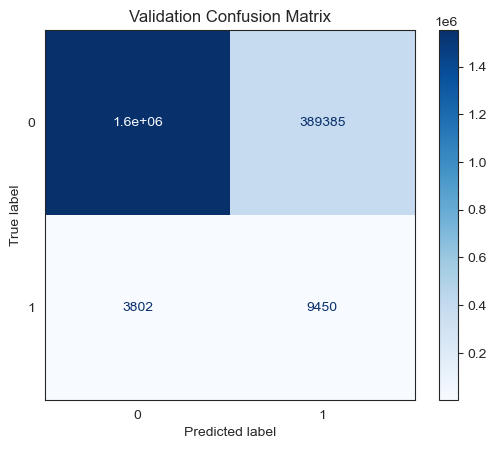

Validation AUC-ROC: 0.84


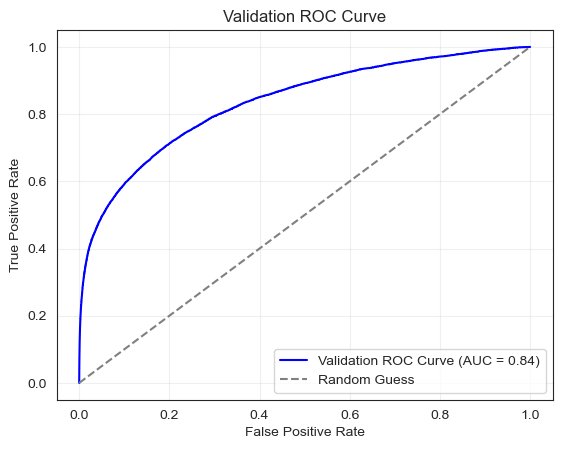

In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = xgb_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=xgb_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = xgb_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


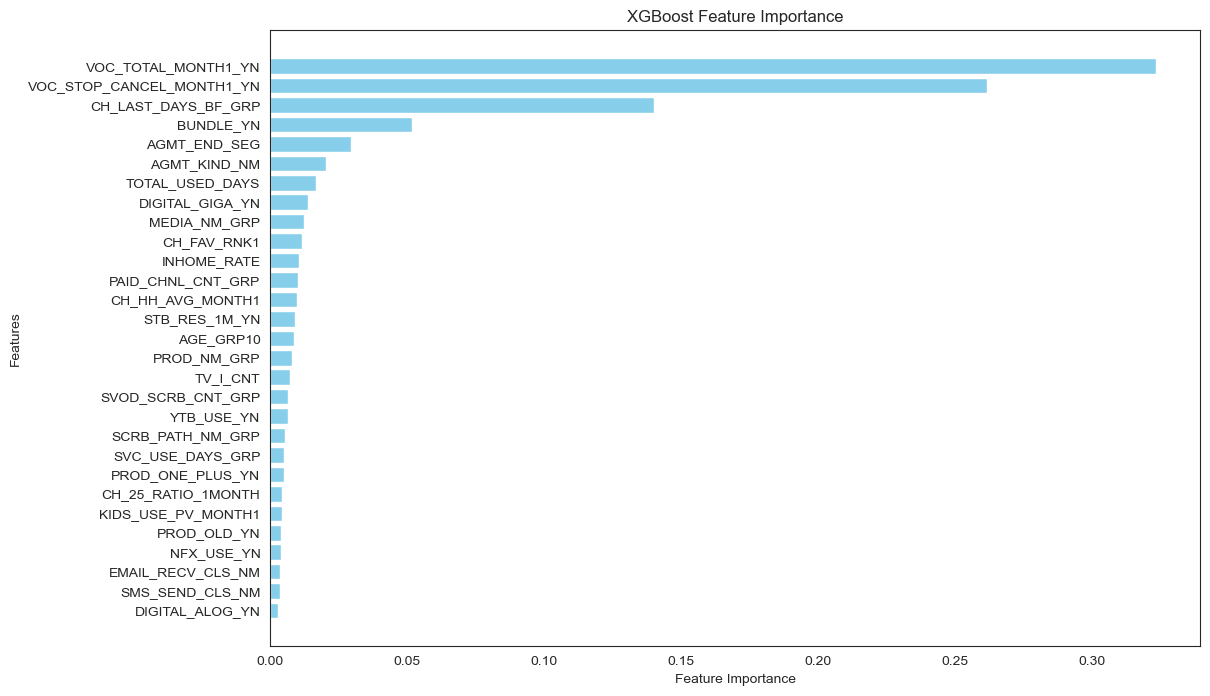

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# XGBoost Feature Importance 추출
feature_importance = xgb_model.feature_importances_

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

### 2. SMOTE-NC 데이터로 XGB 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [7]:
# 레이블 인코딩, 정규화를 진행한 데이터 불러오기.

train = pd.read_csv("data/train/smote_modeling/train.csv")
val = pd.read_csv("data/train/smote_modeling/val.csv")
test = pd.read_csv("data/train/smote_modeling/test.csv")

XGB 학습

In [8]:
from xgboost import XGBClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# XGBoost 모델 생성
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# 모델 학습
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Validation Accuracy: 0.84

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.85      0.91   1941866
           1       0.02      0.48      0.04     13252

    accuracy                           0.84   1955118
   macro avg       0.51      0.66      0.48   1955118
weighted avg       0.99      0.84      0.91   1955118


Confusion Matrix (Validation):
[[1641151  300715]
 [   6873    6379]]


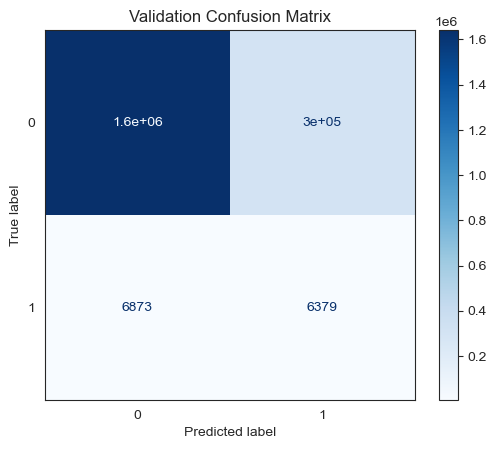

Validation AUC-ROC: 0.73


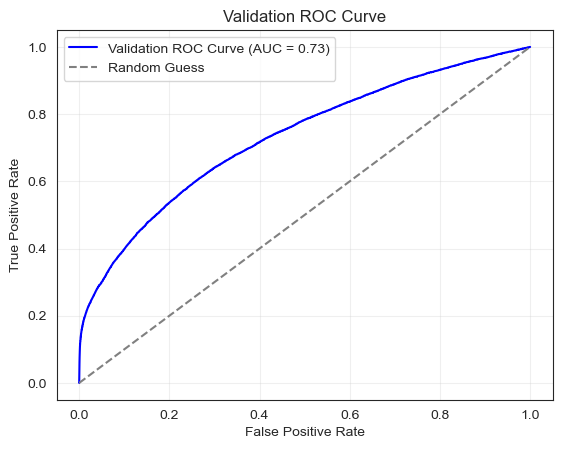

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = xgb_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=xgb_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = xgb_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


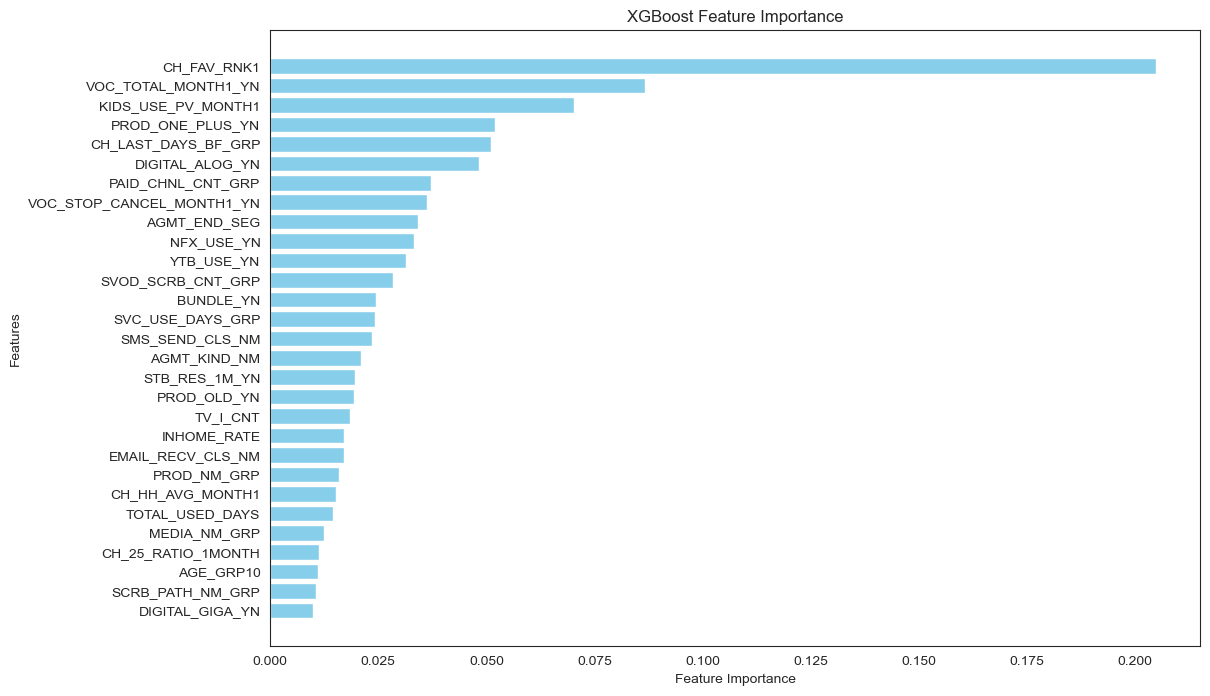

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

### 3. SMOTE-NC + 랜덤 언더 샘플링 데이터로 XGB 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [11]:
# 레이블 인코딩, 정규화를 진행한 데이터 불러오기.

train = pd.read_csv("data/train/smoterandom_modeling/train.csv")
val = pd.read_csv("data/train/smoterandom_modeling/val.csv")
test = pd.read_csv("data/train/smoterandom_modeling/test.csv")

XGB 학습

In [12]:
from xgboost import XGBClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# XGBoost 모델 생성
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# 모델 학습
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Validation Accuracy: 0.87

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.87      0.93   1941866
           1       0.02      0.46      0.04     13252

    accuracy                           0.87   1955118
   macro avg       0.51      0.66      0.49   1955118
weighted avg       0.99      0.87      0.92   1955118


Confusion Matrix (Validation):
[[1687857  254009]
 [   7196    6056]]


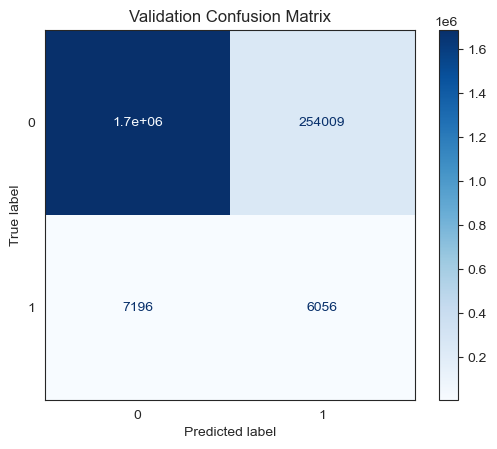

Validation AUC-ROC: 0.74


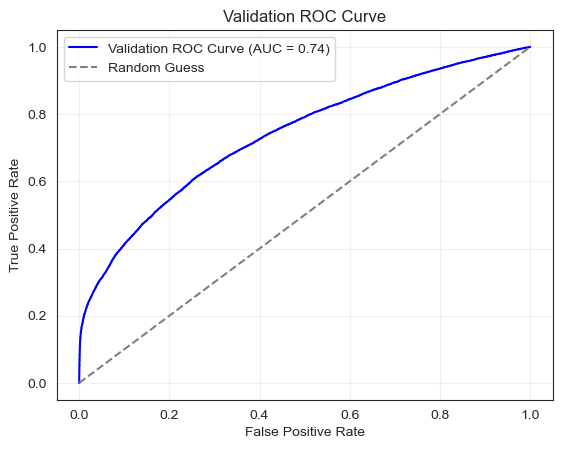

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = xgb_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=xgb_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = xgb_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

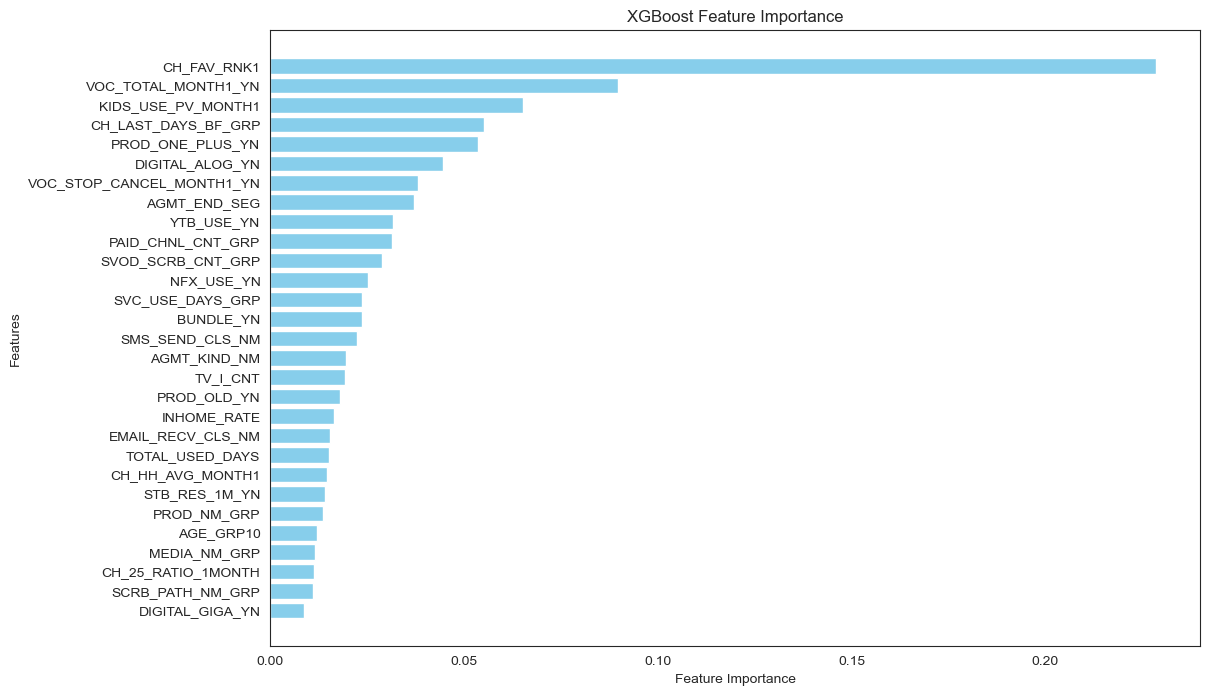

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

### 4. 가중치로 XGB 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [15]:
train = pd.read_csv("data/train/train.csv")
val = pd.read_csv("data/train/validation.csv")
test = pd.read_csv("data/train/test.csv")

In [16]:
val = val.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])
test = test.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])

In [17]:
# INHOME_RATE 컬럼은 object로

train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
val['INHOME_RATE'] = val['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)
print(train['INHOME_RATE'].dtypes)
print(val['INHOME_RATE'].dtypes)
print(test['INHOME_RATE'].dtypes)

object
object
object


In [18]:
# 레이블 인코딩 진행!

from sklearn.preprocessing import LabelEncoder

categorical_cols = train.select_dtypes(include=['object']).columns

# 레이블 인코딩 수행
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    val[col] = le.transform(val[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print("레이블 인코딩 끝")

레이블 인코딩 끝


In [19]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# 내가 정한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1', 'KIDS_USE_PV_MONTH1', 'CH_25_RATIO_1MONTH']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
val[robust_columns] = robust_scaler.transform(val[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
val[minmax_columns] = minmax_scaler.transform(val[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")

robust, minmax 끝


XGB 학습

In [31]:
from xgboost import XGBClassifier

# scale_pos_weight(가중치)를 5, 10, 50, 100, 140 정도로 해봤을 때, 5 정도가 제일 나았음.

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    # 가중치
    scale_pos_weight=5,
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Validation Accuracy: 0.68

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.68      0.81   1941866
           1       0.01      0.65      0.03     13252

    accuracy                           0.68   1955118
   macro avg       0.51      0.67      0.42   1955118
weighted avg       0.99      0.68      0.80   1955118


Confusion Matrix (Validation):
[[1312571  629295]
 [   4575    8677]]


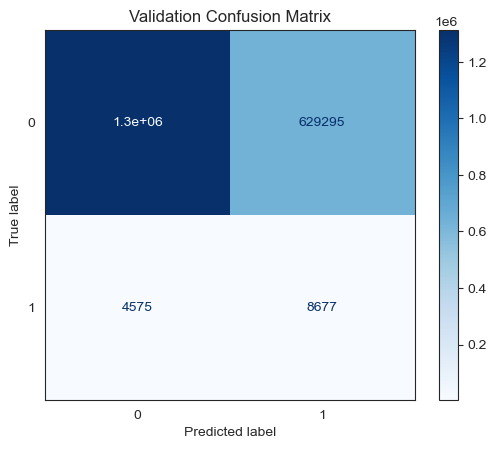

Validation AUC-ROC: 0.73


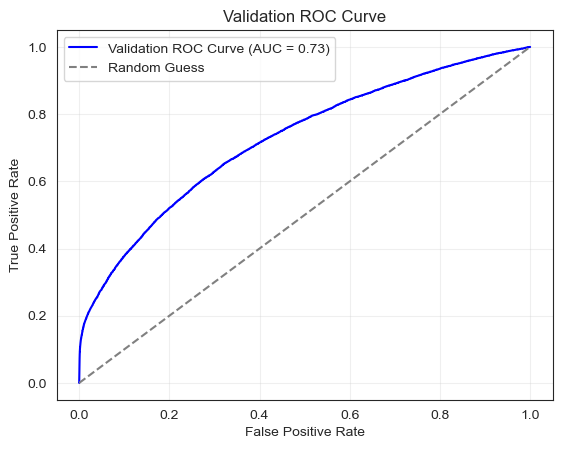

In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = xgb_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=xgb_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = xgb_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


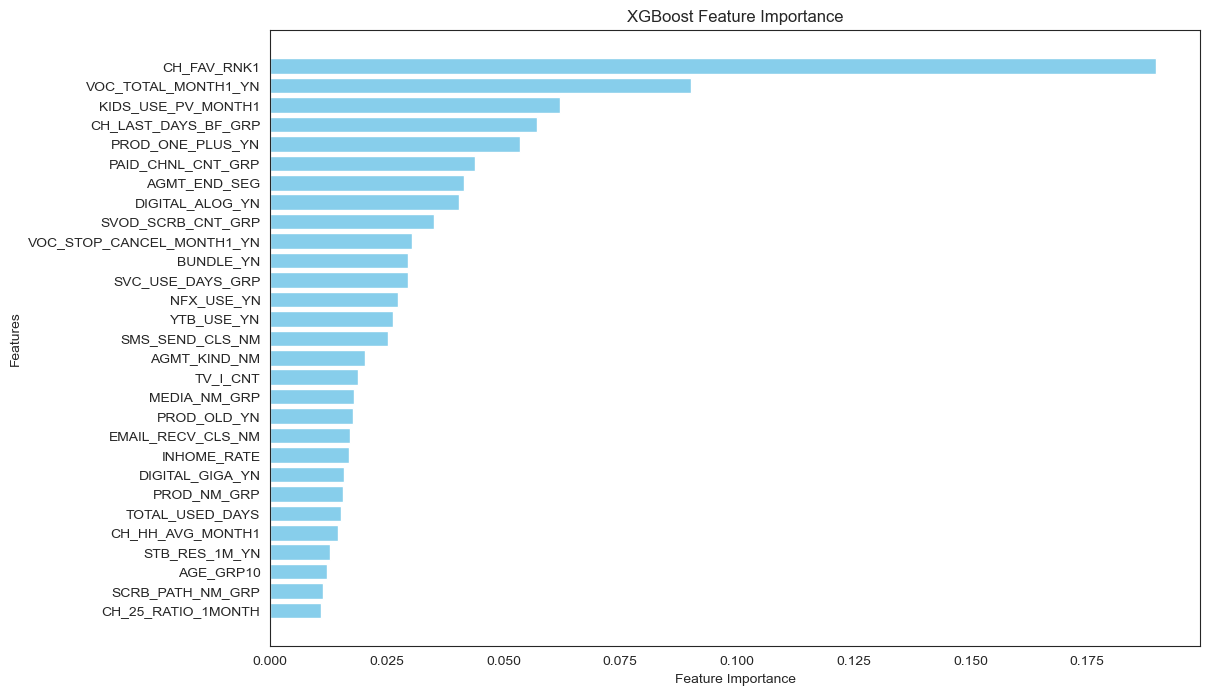

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

#### 결론
XGB는 랜덤 언더를 했을 때, 가장 좋다

### 📌 XGB 성능 비교 (Sampling 기법별)

| 샘플링 기법             | Accuracy | 1의 Recall | ROC-AUC |
|------------------------|----------|-----------|---------|
| <span style="color:red;">**랜덤 언더샘플링**</span>     | 0.80     | 0.71      | 0.84    |
| **SMOTE**              | 0.84     | 0.48      | 0.73    |
| **SMOTE + 랜덤 언더샘플링** | 0.87     | 0.46      | 0.74    |
| **가중치 조정**       | 0.68     | 0.65      | 0.73    |